# TCC 2 - Yan Borges 

## Importando bibliotecas 

In [1]:
#Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import math
import config
import matplotlib.pyplot as plt

from scipy.io.arff import loadarff

from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import RegressorChain
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import KFold

#Importando as bibliotecas referentes ao XGBoost
import xgboost as xgb

#Biblioteca do Kmeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# from sklearn.model_selection import train_test_split

## Funções

### Modelos

In [2]:
from sklearn import tree


def model_xgboost():
    param = {'max_depth': 4,
             'eta': 0.05, 
             'objective': 'reg:squarederror',
             'booster': 'gbtree',
            }
    bst = xgb.XGBRegressor(**param, n_estimators=100)
    return bst

def model_xgboost_multi():
    param = {'max_depth': 4,
             'eta': 0.05, 
             'objective': 'reg:squarederror',
             'booster': 'gbtree',
            }
    bst = xgb.XGBRegressor(**param, n_estimators=100, tree_method='hist', multi_strategy='multi_output_tree')
    return bst

def Chain_RandomForest():
    reg_chain = RegressorChain(RandomForestRegressor(n_estimators = 50,n_jobs = -1, random_state=0))
    return reg_chain

def Chain_DecisionTree():
    reg_chain = RegressorChain(DecisionTreeRegressor())
    return reg_chain

def model_randomForest():
    regressor = RandomForestRegressor(n_estimators = 50,n_jobs = -1, random_state=0)
    return regressor

def model_dtree():
    regressor = DecisionTreeRegressor()
    return regressor

def model_multi_dtree():
    regressor = MultiOutputRegressor(DecisionTreeRegressor())
    return regressor

def model_multi_randomForest():
    regressor = MultiOutputRegressor(RandomForestRegressor(n_estimators = 50,n_jobs = -1, random_state=0))
    return regressor


### Cálculo de erro 

In [3]:
def computer_RRMSE_list(real_test,result_p,real_train_mean):
    """RRMSE: Relative Root Mean Square Error
        input: real_test: real test data
              result_p: predicted data
              real_train_mean: mean of real train data
        output: RRMSE list """
    
    _list = []

    if result_p[1].shape == ():
        fenzi = 0
        fenmu = 0
        for j in range(result_p.shape[0]):
            fenzi += (result_p[j] - real_test[j])**2
            fenmu += (real_train_mean - real_test[j])**2
        _list.append(math.sqrt(fenzi/fenmu))    
        return _list
    else:
        for i in range(result_p.shape[1]):
            fenzi = 0
            fenmu = 0
            for j in range(result_p.shape[0]):
                fenzi += (result_p[j,i] - real_test[j,i])**2
                fenmu += (real_train_mean[i] - real_test[j,i])**2
            _list.append(math.sqrt(fenzi/fenmu))    
        return _list    


# def calculate_RRMSE(targets, valor, targets_mean):
#     loss_list_RRMSE = computer_RRMSE_list(targets, valor, targets_mean)
#     loss_list_RRMSE_np = np.array(loss_list_RRMSE)
#     mean_error = loss_list_RRMSE_np.mean(axis=0)
#     return mean_error

def calculate_RRMSE(targets, predicted):
    targets_mean = np.mean(targets, axis=0)
    loss_list_RRMSE = computer_RRMSE_list(targets, predicted, targets_mean)
    mean_error = np.array(loss_list_RRMSE).mean(axis=0)
    return mean_error


## Implementação

In [4]:
path = "../TCC/mtr-datasets/"

#text_file = input("dataset: ")
text_file = 'atp1d'
data, meta = loadarff(path + text_file + ".arff")
data = pd.DataFrame(data)

data.reset_index(inplace=True)
data.replace('?', np.nan, inplace=True)
data.replace('     ?', np.nan, inplace=True)
data = data.applymap(float)

#Caso de Exceção por ter coluna com muito Null
if text_file == 'osales':
    conta_na = data.isna().sum()
    conta_na[conta_na > 70].index
    data.drop(columns=conta_na[conta_na > 70].index, inplace=True)

#Normalização
scaler = StandardScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

if config.all_config[text_file].get('sample_random') == True:
    data = data.sample(frac=1,random_state = config.all_config[text_file].get('sample_random_num')).reset_index(drop=True)
data = data.fillna(pd.Series(np.nanmean(data,axis=0),index=data.columns))
label = data.iloc[:,-config.all_config[text_file].get('targets_num'):].values
data = data.iloc[:,:-config.all_config[text_file].get('targets_num')].values

#Lista para comparar resultados de teste no final
error_results = []

### Separação dos dados em Treino e Teste 


In [5]:
# Não estou usando mais 
# x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.25, random_state=42)

# Variables to calculate RRMSE
# real_test_mean = y_test.mean(axis=0)
# real_train_mean = y_train.mean(axis=0)
label_mean = label.mean(axis=0)

## Modelos Tradicionais

### Baseline Regressor 


In [8]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

RRMSE_scorer = make_scorer(calculate_RRMSE, greater_is_better=False)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

#### Random Forest e Decision Tree com cross validate 

In [121]:
score = cross_validate(model_randomForest(), data, label, cv=kfold, scoring=RRMSE_scorer)
score = np.sqrt(-score['test_score']).mean()
print(score)
error_results.append(('RF',score))

0.6284699803105241


In [122]:
score = cross_validate(model_dtree(), data, label, cv=kfold, scoring=RRMSE_scorer)
score = np.sqrt(-score['test_score']).mean()
print(score)
error_results.append(('DT',score))

0.7321736767142738


#### Buscando melhores hiperparâmetros com GridSearchCV

In [123]:
# param_grid = {
#     'splitter': ['best', 'random'],
#     'max_depth': [2, 4, 6, 8, 10],
#     'min_samples_split': [2, 4, 6, 8, 10],
#     'min_samples_leaf': [1, 2, 4, 6, 8, 10]}

# grid_search = GridSearchCV(DecisionTreeRegressor(), param_grid=param_grid, cv=kfold, scoring=RRMSE_scorer)

# grid_search.fit(data, label)
# print(grid_search.best_params_)
# print(np.sqrt(-grid_search.best_score_))
# best_param = grid_search.best_params_

# score = cross_validate(DecisionTreeRegressor(max_depth=best_param['max_depth'], min_samples_split=best_param['min_samples_split'], min_samples_leaf=best_param['min_samples_leaf']), data, label, cv=kfold, scoring=RRMSE_scorer)
# score = np.sqrt(-score['test_score']).mean()
# print(score)
# error_results.append(('DT c/ hiperparâmetro',score))

{'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 6, 'splitter': 'random'}
0.6807295949456877


In [138]:
# param_grid = {
#     'max_depth': [2, 4, 6, 8, 10],
#     'min_samples_split': [2, 4, 6, 8, 10],
#     'min_samples_leaf': [1, 2, 4, 6, 8, 10]}

# grid_search = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, cv=kfold, scoring=RRMSE_scorer)

# grid_search.fit(data, label)
# print(grid_search.best_params_)
# print(np.sqrt(-grid_search.best_score_))
# best_param = grid_search.best_params_

# score = cross_validate(RandomForestRegressor(
#                                             n_estimators=50,
#                                             max_depth=best_param['max_depth'], 
#                                             min_samples_split=best_param['min_samples_split'], 
#                                             min_samples_leaf=best_param['min_samples_leaf']), 
#                        data, label, cv=kfold, scoring=RRMSE_scorer)
# score = np.sqrt(-score['test_score']).mean()
# print(score)



#### Decision Tree Local 

In [126]:
scores = np.zeros(label.shape[1])

for target in range(label.shape[1]):
    y = label[:,[target]].ravel()

    score = cross_validate(DecisionTreeRegressor(), data, y, cv=kfold, scoring=RRMSE_scorer)

    scores[target] = np.sqrt(-score['test_score']).mean()

print("Mean Score: ", scores.mean())

Mean Score:  0.7151314250166899


#### Regressor Chain Padrão RF

In [127]:
score = cross_validate(Chain_RandomForest(), data, label, cv=kfold, scoring=RRMSE_scorer)
score = np.sqrt(-score['test_score']).mean()
print("Regressor chain of Random Forest: ", score)
error_results.append(('Chain of RF',score))

Regressor chain of Random Forest:  0.6168778160626983


#### Regressor Chain Padrão DT

In [128]:
score = cross_validate(Chain_DecisionTree(), data, label, cv=kfold, scoring=RRMSE_scorer)
score = np.sqrt(-score['test_score']).mean()
print("Regressor chain of Random Forest: ", score)
error_results.append(('Chain of DT',score))

Regressor chain of Random Forest:  0.7209656576732939


#### Multi Output Decision Tree

In [129]:
score = cross_validate(model_multi_dtree(), data, label, cv=kfold, scoring=RRMSE_scorer)
score = np.sqrt(-score['test_score']).mean()
print("MultiOutput Regressor DT: ", score)
error_results.append(('MultiOutput DT',score))

MultiOutput Regressor DT:  0.7218491943666001


#### Multi Output Random Forest

In [130]:
score = cross_validate(model_multi_randomForest(), data, label, cv=kfold, scoring=RRMSE_scorer)
score = np.sqrt(-score['test_score']).mean()
print("MultiOutput Regressor RF: ", score)
error_results.append(('MultiOutput RF',score))

MultiOutput Regressor RF:  0.6127940564192164


#### Xgboost

Local

In [135]:
score = cross_validate(model_xgboost(), data, label, cv=kfold, scoring=RRMSE_scorer)
score = np.sqrt(-score['test_score']).mean()
print("XGBoost: ",score)
# error_results.append(('XGBoost',score))

XGBoost:  0.6100128516029643


Multi

In [136]:
score = cross_validate(model_xgboost_multi(), data, label, cv=kfold, scoring=RRMSE_scorer)
score = np.sqrt(-score['test_score']).mean()
print("XGBoost: ",score)
# error_results.append(('XGBoost',score))

XGBoost:  0.6041342800042961


## Método de Clusterização

### Matriz de Dissimilaridade 

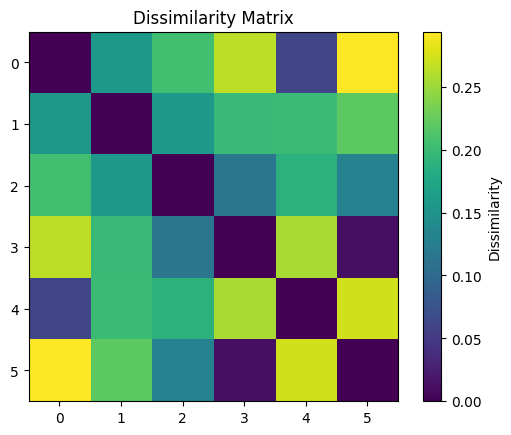

In [31]:
matriz_dissimilaridade = 1 - np.corrcoef(label.T)

plt.imshow(matriz_dissimilaridade, cmap='viridis')
plt.colorbar(label='Dissimilarity')
plt.title('Dissimilarity Matrix')
plt.show()

/var/folders/0f/cyrznsrn06xcrs6sr4j3d8100000gn/T/ipykernel_784/21108651.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(matriz_dissimilaridade, method='average')


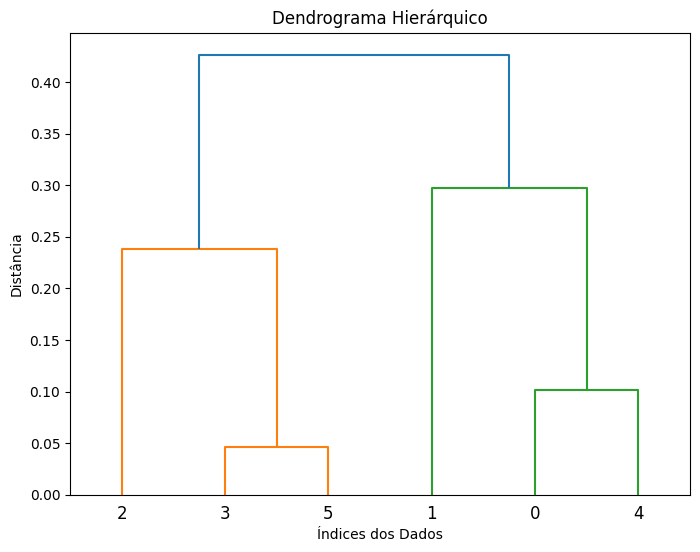

In [32]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
# from scipy.spatial.distance import squareform

linkage_matrix = linkage(matriz_dissimilaridade, method='average')

plt.figure(figsize=(8, 6))
dendrogram(linkage_matrix)
plt.title('Dendrograma Hierárquico')
plt.xlabel('Índices dos Dados')
plt.ylabel('Distância')
plt.show()

Precisa tratar o caso de erro de o ideal ser apenas um cluster

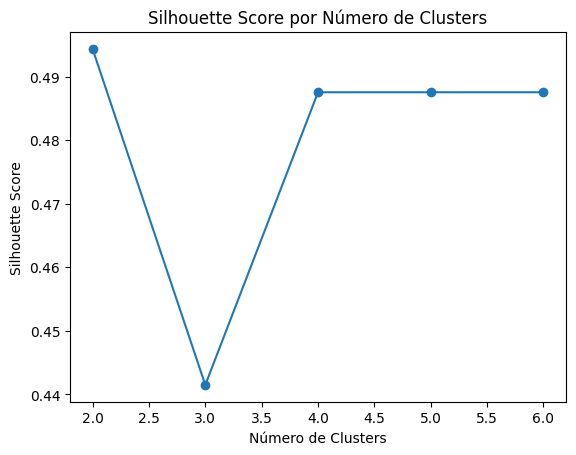

In [33]:
silhouette_scores = []

min_clusters = 2
if label.shape[1] < 10:
    max_clusters = label.shape[1]+1
else:
    max_clusters = 10

for n_clusters in range(min_clusters, max_clusters):
    cluster_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
    silhouette_scores.append(silhouette_score(matriz_dissimilaridade, cluster_labels))

plt.plot(range(min_clusters, max_clusters), silhouette_scores, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score por Número de Clusters')
plt.show()


antigo

In [34]:
# best_cut = silhouette_scores.index(max(silhouette_scores)) + min_clusters
# print('Best number of clusters:', best_cut)

# clusters = fcluster(linkage_matrix, best_cut, criterion='maxclust')

# y_train_cluster = [[] for _ in range(max(clusters))]
# y_test_cluster = [[] for _ in range(max(clusters))]

# # Split the targets into clusters
# for i, cluster in enumerate(clusters):
#     y_train_cluster[cluster-1].append(y_train[:, i])
#     print('Cluster: {}, Target: {}'.format(cluster, i))
#     y_test_cluster[cluster-1].append(y_test[:, i]) 

In [40]:
best_cut = silhouette_scores.index(max(silhouette_scores)) + min_clusters
print('Best number of clusters:', best_cut)

clusters = fcluster(linkage_matrix, best_cut, criterion='maxclust')

label_cluster = [[] for _ in range(max(clusters))]

# Split the targets into clusters
for i, cluster in enumerate(clusters):
    label_cluster[cluster-1].append(label[:, i])
    # print('Cluster: {}, Target: {}'.format(cluster-1, i))

label_cluster = [np.array(cluster).T for cluster in label_cluster]

# print the number of targets in each cluster
for i, cluster in enumerate(label_cluster):
    print('Cluster: {}, Number of targets: {}'.format(i, cluster.shape[1]))

Best number of clusters: 2
Cluster: 0, Number of targets: 3
Cluster: 1, Number of targets: 3


### Regressor Chain de Random Forest Clusterizado

In [37]:
errors = []

for i in range(len(label_cluster)):
    y = label_cluster[i]
    score = cross_validate(Chain_RandomForest(), data, y, cv=kfold, scoring=RRMSE_scorer)
    score = np.sqrt(-score['test_score']).mean()
    errors.append(score)
    # print(score)

error = np.mean(errors)
print("Regressor chain of Random Forest Clusterizado: ", error)
error_results.append(('Clusterizado Chain of RF',error))

Regressor chain of Random Forest Clusterizado:  0.6122266126923178


### Regressor Chain de Decision Tree Clusterizado

In [38]:
errors = []

for i in range(len(label_cluster)):
    y = label_cluster[i]
    score = cross_validate(Chain_DecisionTree(), data, y, cv=kfold, scoring=RRMSE_scorer)
    score = np.sqrt(-score['test_score']).mean()
    errors.append(score)
    # print(score)

error = np.mean(errors)
print("Regressor chain of Decision Tree Clusterizado: ", error)
error_results.append(('Clusterizado Chain of DT',error))

Regressor chain of Decision Tree Clusterizado:  0.7313384916660741


### Random forest Clusterizado

In [39]:
errors = []

for i in range(len(label_cluster)):
    y = label_cluster[i]
    if y.shape[1] == 1:
        y = y.ravel()
    score = cross_validate(model_randomForest(), data, y, cv=kfold, scoring=RRMSE_scorer)
    score = np.sqrt(-score['test_score']).mean()
    errors.append(score)
    # print(score)

error = np.mean(errors)
print("Random Forest Clusterizado: ", error)
error_results.append(('Clusterizado RF',error))

Random Forest Clusterizado:  0.6038325347822753


### Decision Tree Clusterizado

In [147]:
errors = []

for i in range(len(label_cluster)):
    y = label_cluster[i]
    if y.shape[1] == 1:
        y = y.ravel()
    score = cross_validate(model_dtree(), data, y, cv=kfold, scoring=RRMSE_scorer)
    score = np.sqrt(-score['test_score']).mean()
    errors.append(score)
    # print(score)

error = np.mean(errors)
print("Decision Tree Clusterizado: ", error)
error_results.append(('Clusterizado DT',error))

Decision Tree Clusterizado:  0.7241701718681511


### XGBoost Clusterizado

In [148]:
errors = []

for i in range(len(label_cluster)):
    y = label_cluster[i]
    if y.shape[1] == 1:
        y = y.ravel()
    score = cross_validate(model_xgboost(), data, y, cv=kfold, scoring=RRMSE_scorer)
    score = np.sqrt(-score['test_score']).mean()
    errors.append(score)
    # print(score)

error = np.mean(errors)
print("XGBoost Clusterizado: ", error)
error_results.append(('Clusterizado XGBoost',error))

XGBoost Clusterizado:  0.6096394090519638


In [149]:
errors = []

for i in range(len(label_cluster)):
    y = label_cluster[i]
    if y.shape[1] == 1:
        y = y.ravel()
    score = cross_validate(model_xgboost_multi(), data, y, cv=kfold, scoring=RRMSE_scorer)
    score = np.sqrt(-score['test_score']).mean()
    errors.append(score)
    # print(score)

error = np.mean(errors)
print("XGBoost Clusterizado Multi: ", error)
error_results.append(('Clusterizado XGBoost Multi',error))

XGBoost Clusterizado Multi:  0.6098006808664792


## Método de Clusterização Randômica 

Antigo: pois agora itero 10 vezes para ter um resultado melhor 

In [28]:
# ITER = 10

# max_clusters = np.random.randint(2, label.shape[1])

# label_cluster_random = [[] for _ in range(max_clusters)]

# lista = list(range(label.shape[1]))

# # Passo 1: Distribua pelo menos um elemento para cada cluster
# for cluster in range(max_clusters):
#     element = lista.pop(np.random.randint(0, len(lista)))
#     label_cluster_random[cluster-1].append(label[:, element])
#     # print('Initial Cluster: {}, Target: {}'.format(cluster, element))

# # Passo 2: Distribua os elementos restantes de forma aleatória
# while lista:
#     cluster = np.random.randint(0, max_clusters)
#     element = lista.pop(0)
#     label_cluster_random[cluster-1].append(label[:, element])
#     # print('Random Cluster: {}, Target: {}'.format(cluster, element))

# # print()

# for i in range(len(label_cluster_random)):
#     print(np.array(label_cluster_random[i]).T.shape)

In [41]:
ITER = 10

# Inicializa a lista para armazenar os resultados de cada iteração
clusters_rand = []

for _ in range(ITER):
    max_clusters = np.random.randint(2, label.shape[1])
    label_cluster_random = [[] for _ in range(max_clusters)]
    lista = list(range(label.shape[1]))

    # Passo 1: Distribua pelo menos um elemento para cada cluster
    for cluster in range(max_clusters):
        element = lista.pop(np.random.randint(0, len(lista)))
        label_cluster_random[cluster-1].append(label[:, element])

    # Passo 2: Distribua os elementos restantes de forma aleatória
    while lista:
        cluster = np.random.randint(0, max_clusters)
        element = lista.pop(0)
        label_cluster_random[cluster-1].append(label[:, element])

    # Converte cada cluster em um array numpy e adiciona na lista de resultados
    clusters_array = [np.array(cluster).T for cluster in label_cluster_random]
    clusters_rand.append(clusters_array)


# Exibindo as formas de cada iteração para verificação
# for i in range(len(clusters_rand)):
#     print(f'Iteração {i+1}:')
#     for j in range(len(clusters_rand[i])):
#         print(f'  Cluster {j+1}: {clusters_rand[i][j].shape}')


In [25]:
errors = []

for i in range(len(clusters_rand)):
    for j in range(len(clusters_rand[i])):
        y = clusters_rand[i][j]
        if y.shape[1] == 1:
            y = y.ravel()
        score = cross_validate(model_randomForest(), data, y, cv=kfold, scoring=RRMSE_scorer)
        score = np.sqrt(-score['test_score']).mean()
        errors.append(score)
        # print(score)
error = np.mean(errors)
print("Random Forest Clusterizado Random: ", error)

Random Forest Clusterizado Random:  0.6079620503097666


In [27]:
errors = []

for i in range(len(clusters_rand)):
    for j in range(len(clusters_rand[i])):
        y = clusters_rand[i][j]
        if y.shape[1] == 1:
            y = y.ravel()
        score = cross_validate(model_randomForest(), data, y, cv=kfold, scoring=RRMSE_scorer)
        score = np.sqrt(-score['test_score']).mean()
        errors.append(score)
        # print(score)

error = np.mean(errors)
print("Random Forest Clusterizado Random: ", error)
error_results.append(('Random Cluster - RF',error))

Random Forest Clusterizado Random:  0.5852107469909058


In [152]:
errors = []

for i in range(len(clusters_rand)):
    for j in range(len(clusters_rand[i])):
        y = clusters_rand[i][j]
        if y.shape[1] == 1:
            y = y.ravel()
        score = cross_validate(model_dtree(), data, y, cv=kfold, scoring=RRMSE_scorer)
        score = np.sqrt(-score['test_score']).mean()
        errors.append(score)
        # print(score)

error = np.mean(errors)
print("Decision Tree Clusterizado: ", np.mean(errors))
error_results.append(('Random Cluster - DT',error))

Decision Tree Clusterizado:  0.6871690211457031


In [153]:
errors = []

for i in range(len(clusters_rand)):
    for j in range(len(clusters_rand[i])):
        y = clusters_rand[i][j]
        score = cross_validate(Chain_RandomForest(), data, y, cv=kfold, scoring=RRMSE_scorer)
        score = np.sqrt(-score['test_score']).mean()
        errors.append(score)
        # print(score)

error = np.mean(errors)
print("Regressor chain of Random Forest Clusterizado Random: ", error)
error_results.append(('Random Cluster - Chain of RF',error))

Regressor chain of Random Forest Clusterizado Random:  0.59010249346819


In [154]:
errors = []

for i in range(len(clusters_rand)):
    for j in range(len(clusters_rand[i])):
        y = clusters_rand[i][j]
        score = cross_validate(Chain_DecisionTree(), data, y, cv=kfold, scoring=RRMSE_scorer)
        score = np.sqrt(-score['test_score']).mean()
        errors.append(score)
        # print(score)

error = np.mean(errors)
print("Regressor chain of Decision Tree Clusterizado Random: ", error)
error_results.append(('Random Cluster - Chain of DT',error))

Regressor chain of Decision Tree Clusterizado Random:  0.6868797066433097


In [155]:
errors = []

for i in range(len(clusters_rand)):
    for j in range(len(clusters_rand[i])):
        y = clusters_rand[i][j]
        if y.shape[1] == 1:
            y = y.ravel()
        score = cross_validate(model_xgboost(), data, y, cv=kfold, scoring=RRMSE_scorer)
        score = np.sqrt(-score['test_score']).mean()
        errors.append(score)
        # print(score)

error = np.mean(errors)
print("XGBoost Clusterizado Randômico: ", np.mean(errors))
error_results.append(('Random Cluster - XGBoost',error))

XGBoost Clusterizado Randômico:  0.5946698997399864


In [157]:
errors = []

for i in range(len(clusters_rand)):
    for j in range(len(clusters_rand[i])):
        y = clusters_rand[i][j]
        if y.shape[1] == 1:
            y = y.ravel()
        score = cross_validate(model_xgboost_multi(), data, y, cv=kfold, scoring=RRMSE_scorer)
        score = np.sqrt(-score['test_score']).mean()
        errors.append(score)
        # print(score)

error = np.mean(errors)
print("XGBoost Multi Clusterizado Randômico: ", np.mean(errors))
error_results.append(('Random Cluster - XGBoost Multi',error))

XGBoost Multi Clusterizado Randômico:  0.5984787822967055


#### Elbow Method dos targets

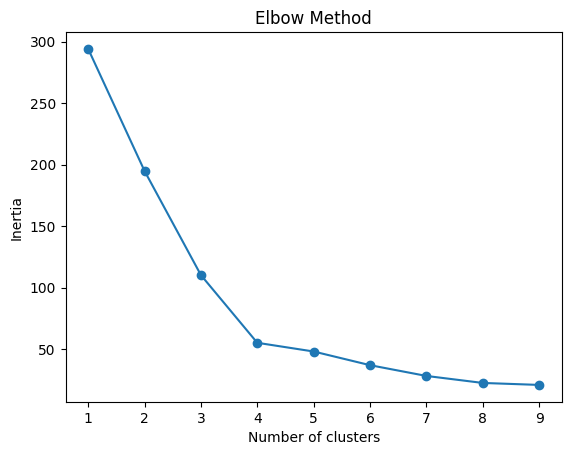

In [34]:
inertia_values = []

for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, random_state=0, n_init='auto').fit(label)
    inertia_values.append(kmeans.inertia_)

plt.plot(range(1, 10), inertia_values, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

## Resultados 

In [158]:
error_results = pd.DataFrame(error_results, columns=['Model', 'RRMSE'])
error_results

,Model,RRMSE
0,RF,0.628470
1,DT,0.732174
2,DT c/ hiperparâmetro,0.689862
3,Chain of RF,0.616878
4,Chain of DT,0.720966
5,MultiOutput DT,0.721849
6,MultiOutput RF,0.612794
7,Clusterizado Chain of RF,0.611170
8,Clusterizado Chain of DT,0.720623
9,Clusterizado RF,0.609152


In [159]:
#ordena os resultados por erro crescente
error_results = error_results.sort_values(by='RRMSE', ascending=True)
error_results

,Model,RRMSE
13,Random Cluster - RF,0.589734
15,Random Cluster - Chain of RF,0.590102
17,Random Cluster - XGBoost,0.594670
18,Random Cluster - XGBoost Multi,0.594670
19,Random Cluster - XGBoost Multi,0.598479
9,Clusterizado RF,0.609152
11,Clusterizado XGBoost,0.609639
12,Clusterizado XGBoost Multi,0.609801
7,Clusterizado Chain of RF,0.611170
6,MultiOutput RF,0.612794


In [160]:
#ordena os resultados por nome do modelo crescente
error_results = error_results.sort_values(by='Model', ascending=True)
error_results

,Model,RRMSE
4,Chain of DT,0.720966
3,Chain of RF,0.616878
8,Clusterizado Chain of DT,0.720623
7,Clusterizado Chain of RF,0.611170
10,Clusterizado DT,0.724170
9,Clusterizado RF,0.609152
11,Clusterizado XGBoost,0.609639
12,Clusterizado XGBoost Multi,0.609801
1,DT,0.732174
2,DT c/ hiperparâmetro,0.689862
